## Q1. LSTM을 이용해 뉴스 카테고리를 예측하는 실습 예제입니다. keras ver. , pytorch.ver 두 가지가 있으니 참고하여 따라와 주세요!

In [ ]:
import torch
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer
import pandas as pd

In [ ]:
device = torch.device("cpu")

**1. LSTM이 RNN의 한계를 극복한 점에 대해 간단히 설명해주세요. (1점)**

답 : 기울기 소실 문제를 어느 정도 예방할 수 있다.

데이터를 불러와 주세요.

설명)class_index는 1,2,3,4로 구성되어 있고,

각각은 1-World, 2-Sports, 3-Business, 4-Science/Tech 로 예측할 뉴스 종류입니다.

In [ ]:
df = pd.read_csv('ag_news.csv')
df.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [ ]:
#뉴스 종류를 categories에 저장합니다.
categories = df['Class Index'].unique()

**2. 뉴스 제목(Title) 열과 요약('Description')열을 합친 내용을 통해 뉴스 종류(Class Index)를 예측할 수 있도록 종속변수 y를 정해주세요. (1점)**

In [ ]:
X = df['Title'] + " " + df['Description']
y =df['Class Index']

다음은 텍스트 데이터를 전처리하겠습니다.

In [ ]:
#가장 긴 문장의 길이 maxlen 출력
maxlen = max(X.map(lambda x: len(x.split())))
print(maxlen)

137


In [ ]:
vocab_size = 10000 #사용할 최대 단어 수 10000으로 한정

tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(X.values) #단어 집합 생성

X_tok = tok.texts_to_sequences(X) #텍스트 데이터 -> 숫자 변환


**3. Tokenized 된 X_tok 를 가장 긴 문장의 길이로 패딩해주세요.(2점)**

In [ ]:
X= pad_sequences(X_tok, maxlen=maxlen, padding='post')

X

array([[1387,    8,  133, ...,    0,    0,    0],
       [   1,  401,   16, ...,    0,    0,    0],
       [7847,   59,  395, ...,    0,    0,    0],
       ...,
       [1597, 1355, 3751, ...,    0,    0,    0],
       [ 146,    4, 1648, ...,    0,    0,    0],
       [1538,  576,   56, ...,    0,    0,    0]], dtype=int32)

클래스 레이블을 이진화하는 코드입니다. 실행해주세요.

In [ ]:
label_encoder = LabelBinarizer()
y_encoded = label_encoder.fit_transform(y)

**4. LSTM 기반의 텍스트 분류 모델을 만들어주세요. 빈칸을 채우시면 됩니다.(2점)**

조건
> 임베딩 벡터의 차원 : 32

> Dropout은 입력의 20% 적용



In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
embed_size = 32

model = Sequential([
    Embedding(vocab_size, embed_size, input_length=maxlen),
    Dropout(0.2),
    LSTM(128), #LSTM 레이어에서 128개의 유닛 사용
    Dense(len(categories), activation='softmax') #FC layer에 해당
])

keras 버전의 훈련 과정입니다.

**5. 손실함수로 categorical_crossentropy, optimizer로 adam을 사용하고, epoch 수는 5로 하여 학습을 진행해주세요.(2점)**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
model.compile(loss=CategoricalCrossentropy(from_logits=False), optimizer=Adam(), metrics=['accuracy'])
model.fit(X, y_encoded, batch_size=256, epochs=5)

Epoch 1/5
30/30 [==============================] - 23s 617ms/step - loss: 1.3865 - accuracy: 0.2471
Epoch 2/5
30/30 [==============================] - 25s 826ms/step - loss: 1.3866 - accuracy: 0.2395
Epoch 3/5
30/30 [==============================] - 30s 1s/step - loss: 1.3865 - accuracy: 0.2503
Epoch 4/5
30/30 [==============================] - 25s 814ms/step - loss: 1.3866 - accuracy: 0.2450
Epoch 5/5
30/30 [==============================] - 18s 586ms/step - loss: 1.3866 - accuracy: 0.2458


잘 훈련되었는지 보기 위해 스포츠 뉴스 토픽과 경제 뉴스 토픽을 넣어 카테고리를 예측해보겠습니다.

실행하고 확인해주세요.

In [ ]:
labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']

test = ['Local Soccer Team Clinches Championship Title in Overtime Thrille']
test_seq = pad_sequences(tok.texts_to_sequences(test), maxlen=maxlen)
test_preds = [labels[np.argmax(i)] for i in model.predict(test_seq)]

for news, label in zip(test, test_preds):
    print('{} - {}'.format(news, label))

1/1 [==============================] - 0s 448ms/step
Local Soccer Team Clinches Championship Title in Overtime Thrille - Science-Technology News


In [ ]:
test2 = ["Global Markets React to Central Bank's Interest Rate Decision"]
test_seq = pad_sequences(tok.texts_to_sequences(test2), maxlen=maxlen)
test_preds = [labels[np.argmax(i)] for i in model.predict(test_seq)]

for news, label in zip(test2, test_preds):
    print('{} - {}'.format(news, label))
print(model.predict(test_seq))

1/1 [==============================] - 0s 37ms/step
Global Markets React to Central Bank's Interest Rate Decision - Business News
1/1 [==============================] - 0s 42ms/step
[[0.24813864 0.2496311  0.2528791  0.24935104]]


아래는 파이토치 버전으로 구현하고, 훈련하는 과정입니다.

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index] - 1
        return x, y

train_set = CustomDataset(X, y)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)

**6. LSTM을 구현해보겠습니다. 빈칸을 채워주세요.(2점)**

In [ ]:
import torch
import torch.nn as nn
import pdb

class LSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers, vocab_size, num_classes):
        # input_size = embed_size
        super(LSTM, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout = 0.2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, num_classes),
            nn.Softmax(dim = 1)
        )


    def forward(self, x):
        # input x : ( batch_size, sequence_length, number of features(Embed_size))
        # LSTM에 초기 h0와 c0를 넣어줄 때 num_layers, batch_size, hidden_size)로 넣어주어야 함.

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        x = self.embed(x)

        # out, (hn, cn) : hn, cn은 n번째에서 hidden state와 Cell state
        # out : (batch, length, hidden_size)
        out, _ = self.lstm(x, (h0, c0))

        # 이 중에서 최종적으로 필요한 것은 마지막으로 예측한 것을 바탕으로 class 예측
        out = self.fc(out[:, -1, :])

        return out

파이토치 버전으로 훈련을 진행하고 예측해보겠습니다. (실행해주세요!)

In [ ]:
learning_rate = 0.001
lstm = LSTM(embed_size, 128, 2, vocab_size, len(categories)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr = learning_rate)

In [ ]:
epochs = 20

for epoch in range(epochs):
    tot_loss = 0
    for inputs in train_loader:
        x, label = inputs
        out = lstm(x)
        loss = criterion(out, label)
        tot_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"epoch : {epoch}, tot_loss : {tot_loss}")


epoch : 0, tot_loss : 41.60564422607422
epoch : 1, tot_loss : 41.59339904785156
epoch : 2, tot_loss : 41.59272003173828
epoch : 3, tot_loss : 41.59384536743164
epoch : 4, tot_loss : 41.59253692626953


In [ ]:
labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']

test = ['Local Soccer Team Clinches Championship Title in Overtime Thrille']
test_seq = pad_sequences(tok.texts_to_sequences(test), maxlen=maxlen)
test_preds = [labels[torch.argmax(i)] for i in lstm(torch.from_numpy(test_seq))]

for news, label in zip(test, test_preds):
    print('{} - {}'.format(news, label))

Local Soccer Team Clinches Championship Title in Overtime Thrille - Sports News


In [ ]:
test2 = ["Global Markets React to Central Bank's Interest Rate Decision"]
test_seq = pad_sequences(tok.texts_to_sequences(test2), maxlen=maxlen)
test_preds = [labels[torch.argmax(i)] for i in lstm(torch.from_numpy(test_seq))]

for news, label in zip(test2, test_preds):
    print('{} - {}'.format(news, label))

Global Markets React to Central Bank's Interest Rate Decision - Business News


##Q2.

In [ ]:
!pip install --user torchtext

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

##***LSTM을 이용하여 스타벅스 주가를 예측해 보겠습니다.(pytorch 사용)***

#1. data에 스타벅스 주가 데이터를 불러와서 저장하세요.(1점)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('SBUX.csv')
print(data.dtypes)
print(data)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
           Date        Open        High         Low       Close   Adj Close  \
0    2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752   
1    2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032   
2    2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046   
3    2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941   
4    2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288   
..          ...         ...         ...         ...         ...         ...   
248  2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787   
249  2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918   
250  2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554   
251  2020-12-09  101.940002  102.209999  100.0999

In [ ]:
# 그냥 실행해 주세요
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

#2. y에 Volume column을, X에 Volume을 제외한 나머지 컬럼을 저장하여 데이터셋을 훈련과 레이블으로 분리하세요 (2점)

In [ ]:
X = data.drop(columns=['Volume'])
y = data[['Volume']]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [ ]:
y

,Volume
Date,
2019-12-11,4921900.0
2019-12-12,10282100.0
2019-12-13,6714100.0
2019-12-16,6705600.0
2019-12-17,7296900.0
...,...
2020-12-04,6952700.0
2020-12-07,4514800.0
2020-12-08,3911300.0


#3. 스케일러를 적용합니다. X_ss에 StandardScaler를, y_ms에 MinMaxScaler를 적용하세요. (2점) 힌트: fit_transform 사용

In [ ]:
#스케일러를 적용합니다.
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

In [ ]:
#그냥 실행해 주세요
X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (200, 5) (200, 1)
Testing Shape : (53, 5) (53, 1)


In [ ]:
# 데이터셋 형태, 크기 조정 그냥 실행해 주세요
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                  1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train_tensors_f.shape, y_train_tensors.shape)
print('Testing Shape :', X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape : torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape : torch.Size([53, 1, 5]) torch.Size([53, 1])


In [ ]:
#네트워크 정의. 그냥 실행해 주세요
class LSTM(nn.Module) :
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) :
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x) :
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

#4. 변수값 설정. 이 변수값들을 이용해 LSTM 모델을 model 변수명에 만드시오. (num_epochs = 1000, learning_rate = 0.0001, input_size = 5, hidden_size = 2, num_layers = 1, num_classes = 1) (2점)

In [ ]:
# 변수값 설정
num_epochs = 1000
learning_rate = 0.0001
input_size= 5
hidden_size= 2
num_layers= 1
num_classes= 1

model = LSTM(num_classes, input_size, hidden_size, num_layers,1)              #앞에서 정의한 값들 이용하여 LSTM모델 정의

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#5. 모델 학습시키기. 순전파 학습과 오차 계산, 역전파 기울기 계산을 수행하시오. (2점)

In [ ]:
#모델 학습시키기
for epoch in range(num_epochs) :
    outputs = model(X_train_tensors_f)               # 순전파 학습 X_train_tensors_f 사용
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)                  # 손실 함수를 이용해 outputs과 y_train_tensors간의 오차 계산
    loss.backward()                        # 역전파 계산

    optimizer.step()
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.09718
Epoch : 100, loss : 0.03060
Epoch : 200, loss : 0.02574
Epoch : 300, loss : 0.02278
Epoch : 400, loss : 0.02046
Epoch : 500, loss : 0.01906
Epoch : 600, loss : 0.01847
Epoch : 700, loss : 0.01827
Epoch : 800, loss : 0.01818
Epoch : 900, loss : 0.01812


In [ ]:
data.iloc[:, :-1]

,Open,High,Low,Close,Adj Close
Date,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752
2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032
2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046
2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941
2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288
...,...,...,...,...,...
2020-12-04,101.349998,102.940002,101.070000,102.279999,101.442787
2020-12-07,102.010002,102.220001,100.690002,101.410004,100.579918
2020-12-08,100.370003,101.570000,100.010002,101.209999,100.381554


In [ ]:
#모델 예측 결과를 출력하기 위한 데이터 크기 재구성. 그냥 실행하세요.
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

#6. 결과 시각화. 그냥 실행하세요. (1점)

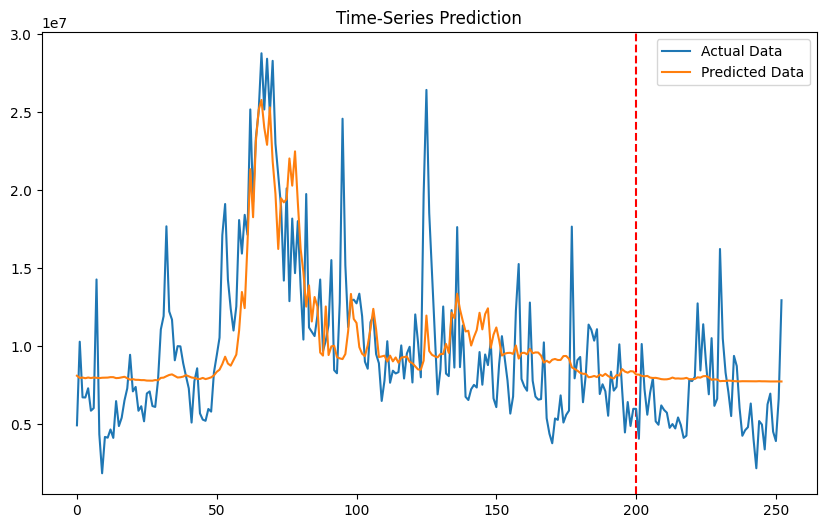

In [ ]:
#결과 시각화
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()